# Image Captioning with Attention

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow import image

import itertools
import random

tf.random.set_seed(1)

Loading the Data. The data consist of pictures and labels of linear functions

In [3]:
import cv2
import os

def load_images_from_folder(folder, n_imgs=-1):
    images = []
    image_nums = []
    for filename in os.listdir(folder)[:n_imgs]:
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
            image_nums.append(filename.strip('.png'))
    return images, image_nums

folder="../../../Math Equations/linear_fcns/images"

In [4]:
images, fnames = load_images_from_folder(folder,10000)

In [5]:
labels = pd.read_csv('../../../Math Equations/linear_fcns/data.csv')

In [6]:
labels['img_number'] = labels['filename'].apply(lambda x: x.split('/')[-1].strip('.png'))

In [7]:
labels.head()

,latex,filename,img_number
0,0a+1=2,linear_fcns/images/0.png,0
1,0b+1=2,linear_fcns/images/1.png,1
2,0c+1=2,linear_fcns/images/2.png,2
3,0d+1=2,linear_fcns/images/3.png,3
4,0e+1=2,linear_fcns/images/4.png,4


In [8]:
label_array = labels[labels['img_number'].isin(fnames)]['latex'].values

For the labels we need to add start and end tokens so the model can recognize what to write.

In [9]:
label_array = [f'\t{la}\n' for la in label_array]

Let's reshape the images so we can plot them.

In [10]:
images_for_split = images
images = np.array(images)
images = 255 - images
# images = tf.image.rgb_to_grayscale(images)
images.shape

(10000, 72, 360, 3)

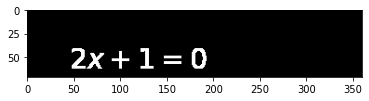

In [11]:
plt.imshow(images[0].squeeze())

Now we can process them and prepare them for inceptionv3 which is transfer learning

In [12]:
img_train, img_test, img_train_name, img_test_name = train_test_split(images, label_array, test_size=.3)

In [13]:
img_mini = tf.image.resize_with_pad(img_train, 299, 299)
img_test= tf.image.resize_with_pad(img_test, 299, 299)

In [14]:
img_mini = tf.keras.applications.inception_v3.preprocess_input(img_mini)
img_test = tf.keras.applications.inception_v3.preprocess_input(img_test)

Now we can load the features of the inceptionv3 model as seen below.

In [149]:
img_mini0 = (img_mini[0] + 1) / 2

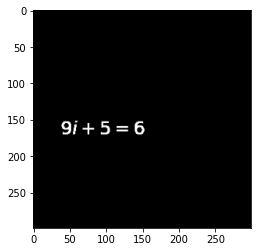

In [150]:
plt.imshow(tf.squeeze(img_mini0))

In [15]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [152]:
# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices((img_mini, img_train_name)).batch(50)#(img_mini, label_array)).batch(1)
c = 1

for img, label in image_dataset:
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))
  
    p = f'../Batch Features Train/batch_features{c}'
    c = c+1 
     #path_of_feature = p.numpy().decode("utf-8")
    np.save(p, batch_features)

In [16]:
img_load = np.load('../Batch Features Train/batch_features1.npy')
for i in range(2,61):
    img_add = np.load(f'../Batch Features Train/batch_features{i}.npy')
    img_load = np.concatenate((img_load, img_add))

FileNotFoundError: [Errno 2] No such file or directory: '../Batch Features Train/batch_features15.npy'

In [17]:
img_load.shape

(7000, 64, 2048)

### Tokenizing the labels

Now we can pad the labels to make sure they are all the same length.

In [47]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [48]:
# Choose the top 5000 words from the vocabulary
top_k = 41
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters=' ',
                                                  char_level=True)
tokenizer.fit_on_texts(img_train_name)#label_array)
train_seqs = tokenizer.texts_to_sequences(img_train_name)

# Padding
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(img_train_name)

# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [49]:
tokenizer.get_config()

{'num_words': 41,
 'filters': ' ',
 'lower': True,
 'split': ' ',
 'char_level': True,
 'oov_token': '<unk>',
 'document_count': 7000,
 'word_counts': '{"\\t": 7000, "4": 2099, "n": 290, "+": 7000, "1": 2094, "=": 7000, "7": 2123, "\\n": 7000, "5": 2137, "z": 272, "3": 2083, "2": 1970, "e": 263, "9": 2143, "6": 2143, "t": 279, "0": 2067, "s": 252, "d": 260, "k": 284, "8": 2141, "i": 274, "r": 293, "b": 250, "q": 270, "x": 268, "l": 263, "y": 265, "p": 275, "j": 281, "w": 257, "o": 262, "v": 266, "h": 274, "a": 269, "u": 261, "c": 255, "f": 274, "g": 250, "m": 293}',
 'word_docs': '{"+": 7000, "7": 2123, "n": 290, "1": 2094, "4": 2099, "\\t": 7000, "=": 7000, "\\n": 7000, "5": 2137, "z": 272, "3": 2083, "9": 2143, "2": 1970, "e": 263, "6": 2143, "t": 279, "s": 252, "0": 2067, "d": 260, "k": 284, "i": 274, "8": 2141, "r": 293, "b": 250, "q": 270, "x": 268, "l": 263, "y": 265, "p": 275, "j": 281, "w": 257, "o": 262, "v": 266, "h": 274, "a": 269, "u": 261, "c": 255, "f": 274, "g": 250, "m"

In [50]:
max_length

8

In [51]:
print(f'{label_array[0]} -> {train_seqs[0]}')

	0i+1=2
 -> [2, 11, 18, 3, 12, 4, 10, 5]


In [52]:
import json

char_to_int_map = tokenizer.get_config()['word_index']
char_to_int_map = json.loads(char_to_int_map)
[char_to_int_map[c] for c in img_train_name[0]]

[2, 11, 18, 3, 12, 4, 10, 5]

In [53]:
# Feel free to change these parameters according to your system's configuration
embedding_dim = 45
units = 32
vocab_size = top_k + 1
num_steps = len(img_train) // 1
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

## Model

Below we are defining the attention, the encoder and the decoder. The encoder is just a fully connected layer from the features already extracted.

In [54]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, 64, units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                             self.W2(hidden_with_time_axis)))

        # score shape == (batch_size, 64, 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, 64, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [55]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        #print(f'This is x: {x}')
        x = tf.nn.relu(x)
        #print(f'This is x: {x}')
        return x

In [65]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)
        #print('decoder attention complete')

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        #print('decoder embedding complete')
        #print(f'x.shape = {x.shape}')
        #print(f'context_vector.shape = {context_vector.shape}')

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        #print('decoder embedding + context vector complete')

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        #print('decoder gru complete')

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)
        #print('decoder fc1 complete')

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))
        #print('decoder reshape complete')

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)
        #print('decoder fc2 complete')

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [66]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [67]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [68]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [69]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
      start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
      # restoring the latest checkpoint in checkpoint_path
      ckpt.restore(ckpt_manager.latest_checkpoint)

In [70]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [71]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

          # initializing the hidden state for each batch
          # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])
    #print(f'hidden complete: {hidden}')

    # Create a vector of all \t indices to indicate the start of prediction
    dec_input = tf.expand_dims([tokenizer.word_index['\t']] * target.shape[0], 1)
    #print(f'dec_input complete: {dec_input}')

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        #print('encoder complete')
        #print(f'features.shape = {features.shape}')

        # iterate through timesteps to predict the i'th character
        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            #print('decoder complete')

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [72]:
image_dataset_encoded = tf.data.Dataset.from_tensor_slices((img_load, cap_vector)).batch(500)

In [87]:
import time
EPOCHS = 10

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(image_dataset_encoded):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 1 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
                epoch + 1, batch, batch_loss / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save() 
    print(num_steps)
    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.7119
Epoch 1 Batch 1 Loss 1.7060
Epoch 1 Batch 2 Loss 1.6932
Epoch 1 Batch 3 Loss 1.6882
Epoch 1 Batch 4 Loss 1.6786
Epoch 1 Batch 5 Loss 1.6690
Epoch 1 Batch 6 Loss 1.6492
Epoch 1 Batch 7 Loss 1.6467
Epoch 1 Batch 8 Loss 1.6321
Epoch 1 Batch 9 Loss 1.6182
Epoch 1 Batch 10 Loss 1.6143
Epoch 1 Batch 11 Loss 1.6043
Epoch 1 Batch 12 Loss 1.5921
Epoch 1 Batch 13 Loss 1.5831
7000
Epoch 1 Loss 0.003298
Time taken for 1 epoch 15.044060230255127 sec

Epoch 2 Batch 0 Loss 1.5676
Epoch 2 Batch 1 Loss 1.5600
Epoch 2 Batch 2 Loss 1.5492
Epoch 2 Batch 3 Loss 1.5389
Epoch 2 Batch 4 Loss 1.5314
Epoch 2 Batch 5 Loss 1.5201
Epoch 2 Batch 6 Loss 1.5022
Epoch 2 Batch 7 Loss 1.4994
Epoch 2 Batch 8 Loss 1.4872
Epoch 2 Batch 9 Loss 1.4731
Epoch 2 Batch 10 Loss 1.4697
Epoch 2 Batch 11 Loss 1.4592
Epoch 2 Batch 12 Loss 1.4522
Epoch 2 Batch 13 Loss 1.4429
7000
Epoch 2 Loss 0.003008
Time taken for 1 epoch 17.255862712860107 sec

Epoch 3 Batch 0 Loss 1.4324
Epoch 3 Batch 1 Loss 1.4275
Epoc

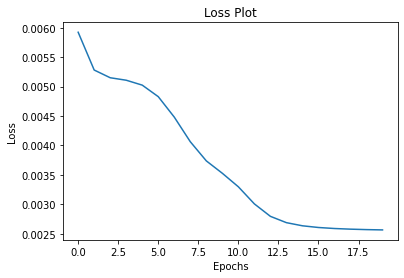

In [88]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

# Evaluate

In [75]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(image, 0)
    #print(temp_input)
    img_tensor_val = image_features_extract_model(temp_input)
    #print(img_tensor_val)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    #print(img_tensor_val)
    
    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['\t']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        attention_plot[i] = tf.reshape(attention_weights, (-1, ))

        predicted_id = tf.random.categorical(predictions, 1)[0][0]
        predicted_id = int(predicted_id)
        result.append(tokenizer.index_word[predicted_id])
        #print(tokenizer.index_word[predicted_id])
        ind = np.argpartition(predictions, -4)[0][-4:]
        #print(f'These are the top choices {"".join(tokenizer.index_word[c] for c in ind)}')
        #print(f'This are the probabilities {predictions.numpy()[0,ind]}')

        if tokenizer.index_word[predicted_id] == '\n':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [76]:
def plot_attention(image, result, attention_plot):
    
    #-1 goes to zero
    temp_image = np.array(image)
    temp_image = (temp_image + 1) / 2

    fig = plt.figure(figsize=(10, 10))
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show();

Run attention_plot to see what it looks like

Prediction Caption: 4 m + 7 = 8 



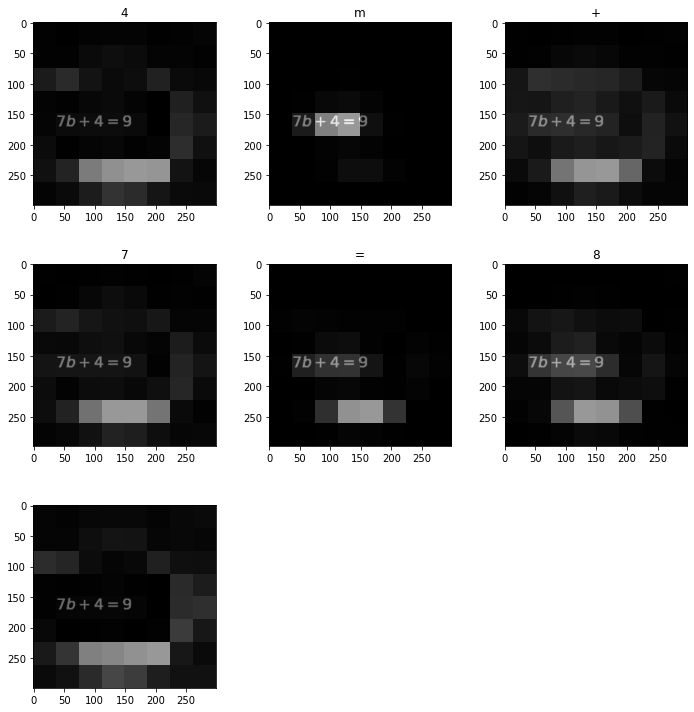

In [89]:
result, attention_plot = evaluate(img_test[0])
print ('Prediction Caption:', ' '.join(result))
plot_attention(img_test[0], result, attention_plot)
# opening the image

Prediction Caption: 6 d + 7 = 1 



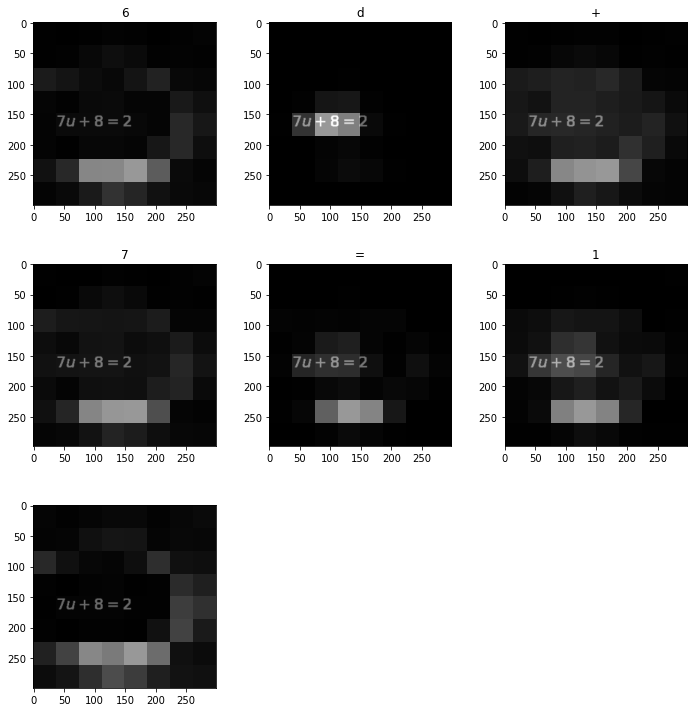

In [90]:
result, attention_plot = evaluate(img_test[9])
print ('Prediction Caption:', ' '.join(result))
plot_attention(img_test[9], result, attention_plot)
# opening the image

Prediction Caption: 2 m + 1 = 1 



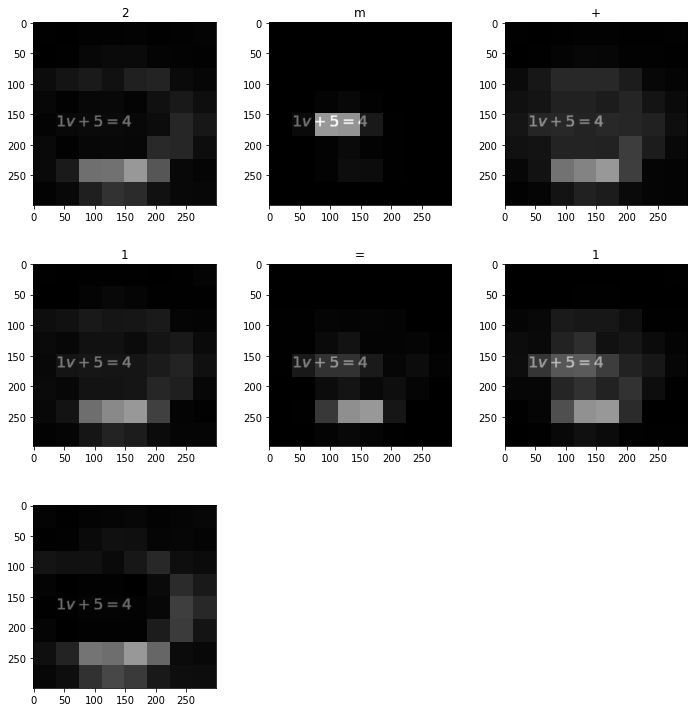

In [91]:
result, attention_plot = evaluate(img_test[5])
print ('Prediction Caption:', ' '.join(result))
plot_attention(img_test[5], result, attention_plot)
# opening the image

In [92]:
def check_results(images, labels, num_imgs=10):
    for i in range(0, num_imgs):
        result, attention_plot = evaluate(images[i])
        print('Prediction Caption:', ' '.join(result))
        print(f'Actual Caption: ', labels[i])
        #plot_attention(images[i], result, attention_plot)

In [93]:
check_results(img_test, img_test_name)

Prediction Caption: 7 p + 0 = 2 

Actual Caption:  	5h+6=3

Prediction Caption: 8 t + 7 = 8 

Actual Caption:  	1v+5=4

Prediction Caption: 8 v + 1 = 8 

Actual Caption:  	0p+6=9

Prediction Caption: 4 q + 0 = 1 

Actual Caption:  	8g+4=6

Prediction Caption: 5 n + 3 = 7 

Actual Caption:  	2i+1=8

Prediction Caption: 6 s + 9 = 5 

Actual Caption:  	9f+5=4

Prediction Caption: 5 z + 4 = 8 

Actual Caption:  	7k+2=9

Prediction Caption: 8 r + 6 = 2 

Actual Caption:  	9a+7=5

Prediction Caption: 7 z + 8 = 3 

Actual Caption:  	3d+0=1

Prediction Caption: 1 z + 6 = 3 

Actual Caption:  	3u+2=4

